<a href="https://colab.research.google.com/github/abeytheo/tinkering-ml/blob/master/face_attribute_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FACE ATTRIBUTE SEGMENTATION

### CONSTRUCT AND PREPROCESS DATASET

In [7]:
### We are gonna use Helen face segmentation dataset
!wget http://pages.cs.wisc.edu/~lizhang/projects/face-parsing/SmithCVPR2013_dataset_resized.zip
!unzip -qq SmithCVPR2013_dataset_resized.zip
!mv SmithCVPR2013_dataset_resized HelenDataset

--2020-05-27 15:07:03--  http://pages.cs.wisc.edu/~lizhang/projects/face-parsing/SmithCVPR2013_dataset_resized.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.26
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358268885 (342M) [application/zip]
Saving to: ‘SmithCVPR2013_dataset_resized.zip’

SmithCVPR2013_datas 100%[===================>] 341.67M  4.00MB/s    in 2m 12s  

2020-05-27 15:09:15 (2.59 MB/s) - ‘SmithCVPR2013_dataset_resized.zip’ saved [358268885/358268885]



#### MERGE SEGMENTATION LABELS

In [0]:
import os
import cv2
from skimage import io, transform
import numpy as np
import numpy as np
import cv2
import os
from os import listdir
import re
import sys

In [0]:
### the following preprocessing codes are modified from https://github.com/nbansal90/Facial_attribute_segmentation/blob/master/image_relabel_10_6.py

folder_dataset = '/content/HelenDataset/'

image_path  = os.path.join(folder_dataset, 'images')
label_path  = os.path.join(folder_dataset, 'labels')
files = os.listdir(image_path)

### resize images
for file in files:
	label_image =  (file.split('.')[0])
	img = os.path.join(image_path, file)
	img = cv2.imread(img)
	height,width,_ = (img.shape)
	os.chdir(image_path)

	dim_min = min(height,width)
	dim_max = max(height,width)
	
	if (dim_min > 200):
		img_new = cv2.resize(img,(200,200),interpolation=cv2.INTER_AREA)
	elif (dim_max < 200):
		img_new = cv2.resize(img,(200,200),interpolation=cv2.INTER_CUBIC)
	else:
		img_new = cv2.resize(img,(200,200))

	cv2.imwrite(file, img_new)
	
	# apply different interpolations depending on size
	os.chdir(label_path)
	label_folder = os.path.join(os.getcwd(), label_image)
	label_folder_files = os.listdir(label_folder)
	os.chdir(label_folder)
	if (dim_min > 200):
		for lff in label_folder_files:
			limg = os.path.join(label_folder, lff)
			limg = cv2.imread(limg)
			limg_new =  cv2.resize(limg,(200,200),interpolation=cv2.INTER_AREA)
			cv2.imwrite(lff, limg_new)
	elif (dim_max < 200):
		for lff in label_folder_files:
			limg = os.path.join(label_folder, lff)
			limg = cv2.imread(limg)
			limg_new = cv2.resize(limg,(200,200),interpolation=cv2.INTER_CUBIC)
			cv2.imwrite(lff, limg_new)
	else:
		for lff in label_folder_files:
			limg = os.path.join(label_folder, lff)
			limg = cv2.imread(limg)
			limg_new = cv2.resize(limg,(200,200))
			cv2.imwrite(lff, limg_new)

In [0]:
### merge labels by combining label images and renaming files

path = label_path
files = listdir(label_path)

### ----------------
### Original labels:
### ----------------
### lbl00 - background
### lbl01 - face skin
### lbl02 - left eyebrow
### lbl03 - right eyebrow
### lbl04 - left eye
### lbl05 - right eye
### lbl06 - nose
### lbl07 - top lip
### lbl08 - inner mouth
### lbl09 - bottom lip
### lbl10 - hair

### --------------
### Target labels:
### --------------
### lbl00 - background
### lbl01 - face skin
### lbl02 - eyebrows
### lbl03 - eyes
### lbl04 - nose
### lbl05 - mouth
### lbl06 - hair

#Merging the two eye brows
def merge_eyebrow(img1, img2, image_folder, label_folder):
    tmp_img1 = img1
    tmp_img2 = img2

    prev_str = re.findall(r'(.*)lbl.*', img1)

    if (len(prev_str) == 0):
        print ("Not able to fetch the Image Name Prefix")
        sys.exit()
    prev_str = str(prev_str[0])
    prev_str = prev_str + 'lbl02.png'

    img1 = os.path.join(label_folder, image_folder, img1)
    img2 = os.path.join(label_folder, image_folder, img2)
    curr_path = os.path.join(label_folder, image_folder)

    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)

    arr1 = np.asarray(img1)
    arr2 = np.asarray(img2)
    arr1 = np.transpose(arr1, (2,0,1))
    arr2 = np.transpose(arr2,(2,0,1))

    (c,h,w) = (arr2.shape)
    arr_new = np.zeros((c,h,w))

    #Replacing the value at index (i,j) with the maximum of two
    for i in range(0,c):
        for j in range(0,h):
            for k in range(0,w):
                arr_new[i][j][k] = max([arr1[i][j][k], arr2[i][j][k]])
    arr_new =  np.transpose(arr_new, (1,2,0))

    os.remove(os.path.join(label_folder, image_folder, tmp_img1))
    os.remove(os.path.join(label_folder, image_folder, tmp_img2))

    cv2.imwrite(os.path.join(label_folder, image_folder, prev_str), arr_new)

#Merging two Eyes
def merge_eyes(img1, img2,image_folder,label_folder):
    tmp_img1 = img1
    tmp_img2 = img2
    prev_str = re.findall(r'(.*)lbl.*', img1)
    if (len(prev_str) == 0):
        print ("Not able to fetch the Image Name Prefix")
        sys.exit()
    prev_str = str(prev_str[0])
    prev_str = prev_str + 'lbl03.png'

    img1 = os.path.join(label_folder, image_folder, img1)
    img2 = os.path.join(label_folder, image_folder, img2)
    curr_path = os.path.join(label_folder, image_folder)

    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)

    arr1 = np.asarray(img1)
    arr2 = np.asarray(img2)
    arr1 = np.transpose(arr1, (2,0,1))
    arr2 = np.transpose(arr2,(2,0,1))

    (c,h,w) = (arr2.shape)
    arr_new = np.zeros((c,h,w))

    #Replacing the value at index (i,j) with the maximum of two
    for i in range(0,c):
        for j in range(0,h):
            for k in range(0,w):
                arr_new[i][j][k] = max([arr1[i][j][k], arr2[i][j][k]])
    arr_new =  np.transpose(arr_new, (1,2,0))
    
    os.remove(os.path.join(label_folder, image_folder, tmp_img1))
    os.remove(os.path.join(label_folder, image_folder, tmp_img2))
    cv2.imwrite(os.path.join(label_folder, image_folder, prev_str), arr_new)

# merging mouth and lips
def merge_mouth(img1, img2, img3,image_folder,label_folder):
    tmp_img1 = img1
    tmp_img2 = img2
    tmp_img3 = img3

    prev_str = re.findall(r'(.*)lbl.*', img1)
    if (len(prev_str) == 0):
        print ("Not able to fetch the Image Name Prefix")
        sys.exit()
    prev_str = str(prev_str[0])
    new_str = prev_str + 'lbl05.png'
    
    img1 = os.path.join(label_folder, image_folder, img1)
    img2 = os.path.join(label_folder, image_folder, img2)
    img3 = os.path.join(label_folder, image_folder, img3)
    curr_path = os.path.join(label_folder, image_folder)

    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)
    img3 = cv2.imread(img3)

    arr1 = np.asarray(img1)
    arr2 = np.asarray(img2)
    arr3 = np.asarray(img3)

    arr1 = np.transpose(arr1, (2,0,1))
    arr2 = np.transpose(arr2,(2,0,1))
    arr3 = np.transpose(arr3,(2,0,1))

    (c,h,w) = (arr2.shape)
    arr_new = np.zeros((c,h,w))

    # replacing the value at index (i,j) with the maximum of two
    for i in range(0,c):
        for j in range(0,h):
            for k in range(0,w):
                arr_new[i][j][k] = max([arr1[i][j][k], arr2[i][j][k], arr3[i][j][k]])
    arr_new =  np.transpose(arr_new, (1,2,0))
    
    
    os.remove(os.path.join(label_folder, image_folder, tmp_img1))
    os.remove(os.path.join(label_folder, image_folder, tmp_img2))
    os.remove(os.path.join(label_folder, image_folder, tmp_img3))

    cv2.imwrite(os.path.join(label_folder, image_folder, new_str), arr_new)
    
    # rename files to 
    prev_name = prev_str + 'lbl06.png'
    curr_name = prev_str + 'lbl04.png'
    os.rename(os.path.join(label_folder, image_folder, prev_name), os.path.join(label_folder, image_folder, curr_name))
    curr_name = prev_str + 'lbl06.png'
    prev_name = prev_str + 'lbl10.png'
    os.rename(os.path.join(label_folder, image_folder, prev_name), os.path.join(label_folder, image_folder, curr_name))
    
# reducing the Semantic regions from 11 to 7
def merge_images_seven_group(merge_image_list, image_folder,  label_folder):
  merge_eyebrow(merge_image_list[0], merge_image_list[1], image_folder, label_folder)
  merge_eyes(merge_image_list[2], merge_image_list[3],image_folder,label_folder)
  merge_mouth(merge_image_list[4], merge_image_list[5],merge_image_list[6],image_folder,label_folder)

# for training simplicity, convert images to grey scale
def  convert_to_greyscale(path, files):
    for f in files:
        if not os.path.isdir(f):
            continue
        p = path + '/' + f
        os.chdir(p)
        images = listdir(p)
        for image in images:
            img = cv2.imread(image)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            cv2.imwrite(image, img)


In [0]:
for f in files:
  p = path + '/' + f
  if not os.path.isdir(p):
      continue
  images =  (os.listdir(p))
  merge_image_list = []
  
  for image in images:
      r2 = re.findall(r'(.*lbl02.png)', image)
      if (len(r2) > 0):
          merge_image_list.append(str(r2[0]))
      r3 = re.findall(r'(.*lbl03.png)', image)
      if (len(r3) > 0):
          merge_image_list.append(str(r3[0]))
      r4 = re.findall(r'(.*lbl04.png)', image)
      if (len(r4) > 0):
          merge_image_list.append(str(r4[0]))
      r5 = re.findall(r'(.*lbl05.png)', image)
      if (len(r5) > 0):
          merge_image_list.append(str(r5[0]))
      r7 = re.findall(r'(.*lbl07.png)', image)
      if (len(r7) > 0):
          merge_image_list.append(str(r7[0]))
      r8 = re.findall(r'(.*lbl08.png)', image)
      if (len(r8) > 0):
          merge_image_list.append(str(r8[0]))
      r9 = re.findall(r'(.*lbl09.png)', image)
      if (len(r9) > 0):
          merge_image_list.append(str(r9[0]))
  merge_image_list = sorted(merge_image_list)
  merge_images_seven_group(merge_image_list, f, path)

In [0]:
convert_to_greyscale(path, files)

#### DATASET AND DATALOADER

In [0]:
import random
from torchvision.transforms import functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch

from PIL import Image
from skimage import io, transform
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

"""
  Dataset object. For each item, it will return tuple of (image, label)
  The label is a 2D tensor with H x W dimension where each pixel corresponds to a class index
"""
class HelenData(Dataset):

	def __init__(self, folder_dataset, training_file,transform_list=None,is_train=True):
		super(HelenData,self).__init__()
		self.file_name = []
		self.images = 'images'
		self.labels = 'labels'
		self.root = folder_dataset
		self.transform_list = transform_list
		self.is_train = is_train

		for t in training_file:
			with open(folder_dataset + t) as f:
				for line in f:
					item = line.split(',')[-1].rstrip().lstrip()
					if item != '':
						self.file_name.append(item)
		
	def __getitem__(self, index):
		image_folder = os.path.join(self.root, self.images)
		img_name = os.path.join(image_folder, self.file_name[index]+ '.jpg')
		img_ret = self.file_name[index] + '.jpg'

		img = io.imread(img_name)
		img = rgb2gray(img)
		if self.transform_list:
				img = self.transform_list(Image.fromarray(img))
		img = np.asarray(img)
		
		label_folder = os.path.join(self.root, self.labels)
		label_name =  os.path.join(label_folder, self.file_name[index])
		label_files = os.listdir(label_name)
		
		label_img = []
		for label_file in label_files:
			label_img.append(os.path.join(label_name, label_file))
		label_img = sorted(label_img)

		merge_label = np.zeros((128,128))
		c = 1
		for index, i in enumerate(label_img):
      ### ignore several segment labels (background, eyebrows, faceskin, hair)
			if 'lbl00' in i or 'lbl01' in i or 'lbl02' in i or 'lbl06' in i:
				continue
			
			tmp = io.imread(i)
			tmp = transform.resize(tmp,(128,128))
			tmp = np.round(rgb2gray(np.asarray(tmp))).astype('uint8')

      ### c equals class index
			merge_label += c * tmp
			c += 1
		
    ### merge all labels to a single 2D-array with H x W dimension
		label = merge_label
		if self.is_train:
			img, label = self.augment(img,label)
	
		img = torch.from_numpy(np.asarray(img))
		label = torch.from_numpy(np.asarray(label))

		return (img.unsqueeze(0), label.long())

	def __len__(self):
		return len(self.file_name)
	
  ### augment data by random horizontal flipping during training
	def augment(self, image, label):
		if random.random() < 0.5:
			image = F.hflip(Image.fromarray(image))
			label = F.hflip(Image.fromarray(label))
		
		return image, label

In [0]:
dataset_train = HelenData('/content/HelenDataset/',['exemplars.txt','tuning.txt'], transform_list=transforms.Compose(
		[transforms.Resize((128,128))]))
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=32,
		shuffle=True)

dataset_val = HelenData('/content/HelenDataset/',['testing.txt'], transform_list=transforms.Compose(
		[transforms.Resize((128,128))]),is_train=False)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=1,
		shuffle=True)

#### VISUALIZE SEGMENTS

In [0]:
### decode class labels to RGB colors
def decode_segmentation_label(label):
  color_map = {
      0: torch.tensor([[0.7],[0.7],[0.7]],dtype=torch.float),
      1: torch.tensor([[0],[1],[0]],dtype=torch.float),
      2: torch.tensor([[1],[0],[0]],dtype=torch.float),
      3: torch.tensor([[0],[0],[1]],dtype=torch.float),
  }
  
  segmap = torch.ones(3,128,128)
  for k,color in color_map.items():
    indices = (label == k).nonzero()
    segmap[:,indices[:,0],indices[:,1]] = color
  return segmap.transpose(2,0).transpose(0,1)

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


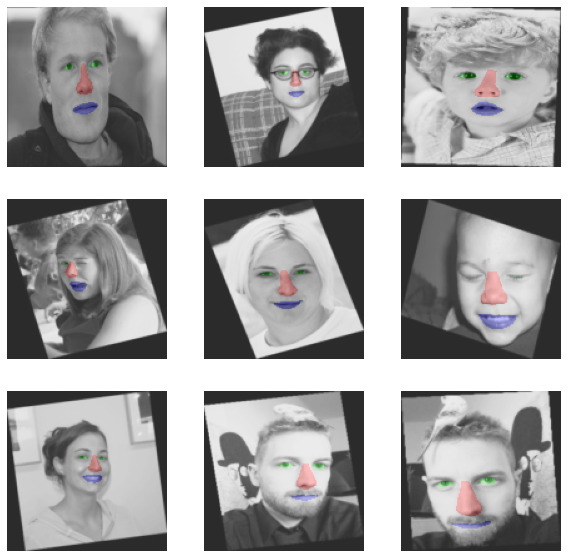

In [7]:
plt.figure(figsize=(10,10))
for c, (img, lbl) in enumerate(dataset_train):
  
  if c > 8:
    break

  plt.subplot(3,3,c+1)
  plt.imshow(img[0],cmap='Greys_r')
  seg_color = decode_segmentation_label(lbl)
  plt.imshow(seg_color,alpha=0.25)
  plt.axis('off')
  

### NETWORK ARCHITECTURE

In [0]:
import argparse
import os
import shutil
import time
import pickle
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data

from torch.autograd import Variable

In [0]:
device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device("cuda:0")

In [0]:
### UNet Generator
class UnetGenerator(nn.Module):
    """
      source: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
      Create a Unet-based generator
    """

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class UnetSkipConnectionBlock(nn.Module):
    """
        source: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py

        Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

### TRAINING AND EVALUATION PIPELINE 

In [0]:
unique_labels = [0,1,2,3]
model_dir = '/content/segmentation_model/'

if not os.path.exists(model_dir):
  os.makedirs(model_dir)
save_model_every = 50

"""
  Average metric container
"""
class AverageMeter(object):
	"""Computes and stores the average and current value"""
	def __init__(self):
		self.reset()

	def reset(self):
		self.val = 0
		self.avg = 0
		self.sum = 0
		self.count =0

	def update(self, val, n=1):
		self.val = val
		self.sum += val*n
		self.count += n
		self.avg = self.sum / self.count

"""
  train pipeline
"""
def train(train_loader, model, criterion, optimizer, epoch):
  """Train for one epoch on the training set"""
  batch_time = AverageMeter()
  losses = AverageMeter()
  classes_metric = {}

  ### init class metric dictionaries
  for u in unique_labels:
    classes_metric[u] = {
        'precision':AverageMeter(),
        'recall':AverageMeter(),
        'iou':AverageMeter()
    }
  across_class_metric = {
      'precision':AverageMeter(),
      'recall':AverageMeter(),
      'iou':AverageMeter()
  }
  
  model.train()
  end = time.time()
  for i, (input, target) in enumerate(train_loader):
    target = target.to(device)
    input = input.float()
    input = input.to(device)
    
    input_var = torch.autograd.Variable(input)
    target_var = torch.autograd.Variable(target)

    output = model(input_var)

    ### cross entropy loss
    loss = criterion(output, target_var)

    ### calculate metrics
    class_m, across_class_m = calculate_segmentation_eval_metric(target,output,unique_labels)

    ### update AverageMeter objects
    losses.update(loss.item(), input.size(0))
    for u in unique_labels:
      for k, _ in classes_metric[u].items():
        classes_metric[u][k].update(class_m[u][k],input.size(0))
    
    for k, _ in across_class_metric.items():
      across_class_metric[k].update(across_class_m[k], input.size(0))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    batch_time.update(time.time() - end)
    end = time.time()

    print('Epoch: [{0}][{1}/{2}]\t'
      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
      .format(
        epoch, i, len(train_loader), batch_time=batch_time,
        loss=losses))
    print('Precision {prec.val: .4f} ({prec.avg: .4f})\t Recall {rec.val: .4f} ({rec.avg: .4f})\t IoU {iou.val: .4f} ({iou.avg: .4f})'.format(prec=across_class_metric['precision'],
                                                                  rec=across_class_metric['recall'],
                                                                  iou=across_class_metric['iou']))
  
  print('-----------------------------')
  print(' Training Summary - Epoch {}'.format(epoch))
  print('-----------------------------')
  for u in unique_labels:
    print("Class {}: Precision {prec.avg: .4f}, Recall {rec.avg: .4f}, IoU {iou.avg: .4f}".format(u,prec=classes_metric[u]['precision'],
                                                                                      rec=classes_metric[u]['recall'],
                                                                                      iou=classes_metric[u]['iou']))
  print("Across Classes: Precision {prec.avg: .4f}, Recall {rec.avg: .4f}, IoU {iou.avg: .4f}".format(prec=across_class_metric['precision'],
                                                                 rec=across_class_metric['recall'],
                                                                 iou=across_class_metric['iou']))
  
  ### save model every "x" epoch
  if epoch > 0 and epoch % save_model_every == 0:
    torch.save(model.state_dict(),os.path.join(model_dir,'face_segment_model_ep{}.pt'.format(epoch)))
  return model, {'loss':losses, 'per_class_metric':classes_metric, 'across_class_metric':across_class_metric}

"""
  validation pipeline
"""
def validate(val_loader, model, criterion, epoch):
  batch_time = AverageMeter()
  losses = AverageMeter()
  classes_metric = {}

  ### init class metric dictionaries
  for u in unique_labels:
    classes_metric[u] = {
        'precision':AverageMeter(),
        'recall':AverageMeter(),
        'iou':AverageMeter()
    }
  across_class_metric = {
      'precision':AverageMeter(),
      'recall':AverageMeter(),
      'iou':AverageMeter()
  }
  
  model.eval()
  end = time.time()
  
  for i, (input, target) in enumerate(val_loader):
    target = target.to(device)
    input = input.float()
    input = input.to(device)
    input_var = torch.autograd.Variable(input)
    target_var = torch.autograd.Variable(target)
    output = model(input_var)

    ### cross entropy loss
    loss = criterion(output, target_var)
    
    ### calculate metrics
    class_m, across_class_m = calculate_segmentation_eval_metric(target,output,unique_labels)

    ### update AverageMeter objects
    for u in unique_labels:
      for k, _ in classes_metric[u].items():
        classes_metric[u][k].update(class_m[u][k],input.size(0))
    
    for k, _ in across_class_metric.items():
      across_class_metric[k].update(across_class_m[k], input.size(0))
    
    losses.update(loss.item(), input.size(0))

    batch_time.update(time.time() - end)
    end = time.time()
  print('-------------------')
  print('Validation Summary')
  print('-------------------')
  print('Loss: {loss: .4f}'.format(loss=losses.avg))
  for u in unique_labels:
    print("Class {}: Precision {prec: .4f}, Recall {rec: .4f}, IoU {iou: .4f}".format(u,prec=classes_metric[u]['precision'].avg,
                                                                                      rec=classes_metric[u]['recall'].avg,
                                                                                      iou=classes_metric[u]['iou'].avg))
  print("Across Classes: Precision {prec.avg: .4f}, Recall {rec.avg: .4f}, IoU {iou.avg: .4f}".format(prec=across_class_metric['precision'],
                                                                 rec=across_class_metric['recall'],
                                                                 iou=across_class_metric['iou']))
  print(" ")
  return {'loss':losses, 'per_class_metric':classes_metric, 'across_class_metric':across_class_metric}
  
"""
  desc:
    calculate average precision, recall, and IoU metric across all classes
    as well as per individual class
  param:
    labels: segmentation labels /w class indices
    outputs: network prediction
    unique_labels: list of class indices
  return:
    metrics per individual class and average metrics accross all classes
"""
def calculate_segmentation_eval_metric(labels,outputs,unique_labels):

  prediction = torch.argmax(outputs,1)

  eps = 1e-32
  batch = labels.shape[0]
  metric = {}

  across_class_metric = {
      'precision': 0,
      'recall': 0,
      'iou': 0
  }

  for u in unique_labels:
    g = labels.detach().clone().view(batch,-1)
    p = prediction.detach().clone().view(batch,-1)

    ### count pixels with class indices equal to "u" both on labels and predictions
    g[g == u] = -1
    g[g != -1] = 0
    g[g == -1] = 1

    p[p == u] = -1
    p[p != -1] = 0
    p[p == -1] = 1

    ### compute Intersection over Union metric
    intersection = (p & g).sum(1).float()
    union = (p | g).sum(1).float()
    iou = intersection / (union + eps)

    ### how many predicted pixels are true
    precision = ((intersection) / (p.sum(1) + eps))

    ### how many true pixels are returned
    recall = ((intersection) / (g.sum(1) + eps))

    metric[u] = {'precision': precision.mean(), 'recall': recall.mean(), 'iou': iou.mean()}
    across_class_metric['precision'] += precision.mean()
    across_class_metric['recall'] += recall.mean()
    across_class_metric['iou'] += iou.mean()
  
  across_class_metric['precision'] = across_class_metric['precision'] / len(unique_labels)
  across_class_metric['recall'] = across_class_metric['recall'] / len(unique_labels)
  across_class_metric['iou'] = across_class_metric['iou'] / len(unique_labels)

  return metric, across_class_metric

### TRAINING LOOP

In [12]:
import functools
n_classes = 4

### use UNet as the encoder-decoder architecture
### the model will output N x C x H x W tensor, where N = batch size, C = number of classes (4 in this case), H x W = image dimension
model = UnetGenerator(1, n_classes, 7, ngf=32, norm_layer=functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True), 
                                 use_dropout='False')
model = model.to(device)
print('Number of model parameters: {}'.format(
  sum([p.data.nelement() for p in model.parameters()])))

### use weighted cross entropy loss since the number of face attributes' pixels are significantly lower
### causing an imbalanced dataset problem
w = torch.tensor([0.1,1.2,0.7,0.7])
weight_criterion = nn.CrossEntropyLoss(weight=w).to(device)

### use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))

Number of model parameters: 10461508


In [13]:
import pickle

train_hist = []
val_hist = []
num_epoch = 100

for epoch in range(num_epoch):
  model, train_metric = train(train_loader, model, weight_criterion, optimizer,epoch)
  val_metric = validate(val_loader, model, weight_criterion, epoch)
  train_hist.append(train_metric)
  val_hist.append(val_metric)

  ### save metric every 10 epoch
  if epoch % 10 == 0 and epoch > 0:
    with open(os.path.join(model_dir,'train_hist.pickle'), 'wb') as handle:
      pickle.dump(train_hist, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(model_dir,'eval_hist.pickle'), 'wb') as handle:
      pickle.dump(val_hist, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch: [83][7/70]	Time 1.341 (1.304)	Loss 0.3486 (0.3483)	
Precision  0.8359 ( 0.8493)	 Recall  0.9949 ( 0.9918)	 IoU  0.8320 ( 0.8433)
Epoch: [83][8/70]	Time 1.288 (1.302)	Loss 0.3483 (0.3483)	
Precision  0.8069 ( 0.8446)	 Recall  0.9962 ( 0.9923)	 IoU  0.8046 ( 0.8390)
Epoch: [83][9/70]	Time 1.368 (1.309)	Loss 0.3478 (0.3482)	
Precision  0.8653 ( 0.8466)	 Recall  0.9927 ( 0.9923)	 IoU  0.8598 ( 0.8411)
Epoch: [83][10/70]	Time 1.226 (1.301)	Loss 0.3482 (0.3482)	
Precision  0.8687 ( 0.8486)	 Recall  0.9866 ( 0.9918)	 IoU  0.8603 ( 0.8428)
Epoch: [83][11/70]	Time 1.227 (1.295)	Loss 0.3476 (0.3482)	
Precision  0.8490 ( 0.8487)	 Recall  0.9941 ( 0.9920)	 IoU  0.8449 ( 0.8430)
Epoch: [83][12/70]	Time 1.168 (1.285)	Loss 0.3483 (0.3482)	
Precision  0.8493 ( 0.8487)	 Recall  0.9831 ( 0.9913)	 IoU  0.8426 ( 0.8430)
Epoch: [83][13/70]	Time 1.173 (1.277)	Loss 0.3476 (0.3481)	
Precision  0.8397 ( 0.8481)	 Recall  0.9959 ( 0.9916)	 IoU  0.8365 ( 0.8425)
Epoch: [83][14/70]	Time 1.118 (1.267)	Loss 0

### RESULTS

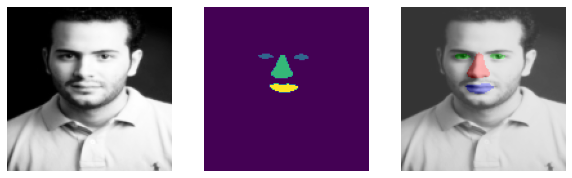

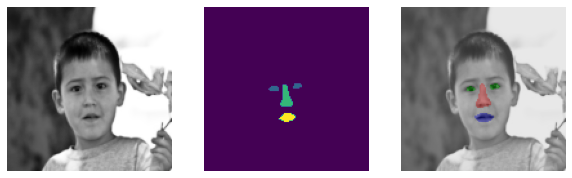

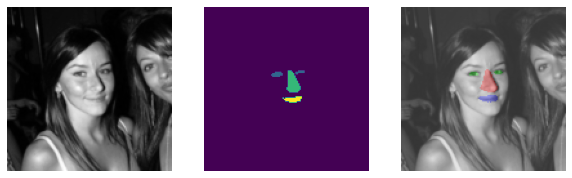

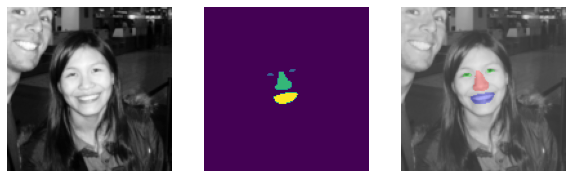

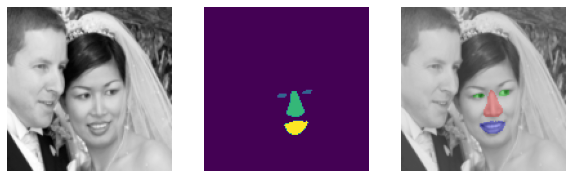

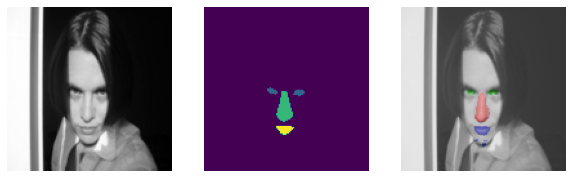

In [29]:
c = 0
for i, (input, target) in enumerate(val_loader):
  if c > 5:
    break

  out = model(input.float().to(device))
  fig, axs = plt.subplots(1, 3, figsize=(10,5))
  axs[0].imshow(input[0][0],cmap='Greys_r')
  axs[0].axis('off')

  axs[1].imshow(target[0])
  axs[1].axis('off')
  prediction = torch.argmax(out[0],0).detach()
  cmap = decode_segmentation_label(prediction)

  axs[2].imshow(input[0][0],cmap='Greys_r')
  axs[2].imshow(cmap,alpha=0.3)
  axs[2].axis('off')
  c += 1

In [0]:
### FIN